Here, we train an autoencoder to process the images from the Algoauns video dataset. The goal is to use the information from the hidden layer as a lower-dimension representation of the original images (dimensionality reduction).
Note: the key is the dimensions of each layer of the autoencoder.

In [ ]:
!pip install decord
from decord import VideoReader
from decord import cpu
from google.colab import drive
import glob
import matplotlib.pyplot as plt
import math
import numpy as np
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import random
import nltk

import numpy as np
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from tqdm.notebook import tqdm, trange



     |████████████████████████████████| 13.6 MB 76 kB/s 


In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device


In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed) 


In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


 Authorise access to Google Drive, where the input viedos are

In [ ]:
# Authorise access to Google Drive, where the input viedos are
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# imported from Algonauts challenge colab
def sample_video_from_mp4(file, num_frames=16):
    """This function takes a mp4 video file as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(file, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images,num_frames

In [ ]:
def plot_conv_ae(conv_losses):
  plt.figure()
  #plt.plot(lin_losses)
  plt.plot(conv_losses)
  plt.legend('Conv AE')
  plt.xlabel('Training batch')
  plt.ylabel('MSE Loss')
  #plt.ylim([0,
           # 2*max(torch.as_tensor(conv_losses).median(),
             #     torch.as_tensor(lin_losses).median())])
  plt.show()

In [ ]:
# Load videos
#@title Visualize video
vid_id = 45 #@param {type: "integer"}
video_dir = '/content/drive/Shared drives/nma_dl_conv_ok/data/participants_data/AlgonautsVideos268_All_30fpsmax'

########### Video display code #################################################
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()

#visualize_brain_activity(video_dir,fmri_train_all,vid_id)
from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_list[vid_id],'rb').read()

In [ ]:
vr = VideoReader(video_list[vid_id], ctx=cpu(0))
total_frames = len(vr)
total_frames

90

45


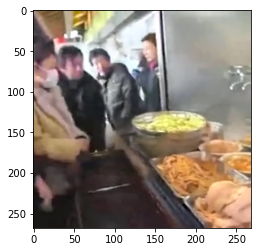

In [ ]:
print(vid_id)
vr = VideoReader(video_list[vid_id], ctx=cpu(0))
inputImage=vr[vid_id].asnumpy()
plt.imshow(inputImage)
plt.show()

In [ ]:
print(inputImage.shape)

(268, 268, 3)


In [ ]:
len(video_list)

1111

## Prepare the data - From videos to images

In [ ]:
# #get middle frame from each video, create image stack of input images, size (numImages, height, width, channels)
# for i in range(len(video_list)):
#   vr = VideoReader(video_list[i], ctx=cpu(0))
#   middleImage=vr[math.floor(len(vr)/2)].asnumpy() 
#   if i==0:
#     data=middleImage[np.newaxis]
#   else:
#     data=np.concatenate([data,middleImage[np.newaxis]],axis=0)
#   #print(len(vr))
#   #print(inputImage.shape)



In [ ]:
# np.save('/content/drive/Shared drives/nma_dl_conv_ok/data/middleImages/middleImages',data)
data=np.load('/content/drive/Shared drives/nma_dl_conv_ok/data/middleImages/middleImages.npy')

In [ ]:
print(data.shape)

(1111, 268, 268, 3)


In [ ]:
print(data[1].shape)

(268, 268, 3)


In [ ]:
print(len(data))

1111


In [ ]:
print(data.shape[0])

1111


In [ ]:
data_torch=torch.from_numpy(data).permute(0,3,1,2)
print(data_torch.shape)

torch.Size([1111, 3, 268, 268])


In [ ]:
data_torch=data_torch.byte()

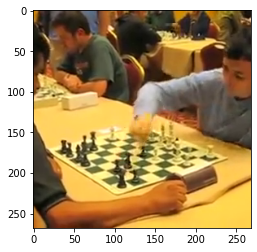

In [ ]:
plt.imshow(data[6])
plt.show()

In [ ]:
data_shape=data_torch[1].shape
data_size=len(data_torch)
dataset_name='middleImages'

## Separate train and validation sets

In [ ]:
batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(data_torch)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_set = torch.utils.data.DataLoader(data_torch, batch_size=batch_size, 
                                           sampler=train_sampler)
valid_set = torch.utils.data.DataLoader(data_torch, batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
len(train_set)

28

In [ ]:
len(valid_set)

7

In [ ]:
len(train_indices)

889

In [ ]:
len(val_indices)

222

##Convolutional non-linear autoencoder

In [ ]:
def train_autoencoder(autoencoder, dataset, device, epochs=20, batch_size=32,
                      seed=0):
  autoencoder.to(device)
  optim = torch.optim.Adam(autoencoder.parameters(),
                           lr=1e-3,
                           weight_decay=1e-5)
  loss_fn = nn.MSELoss()
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=2,
                      worker_init_fn=seed_worker,
                      generator=g_seed)

  #mse_loss = torch.zeros(epochs * len(dataset) // batch_size, device=device)
  
  mse_loss=[]
  i = 0
  for epoch in trange(epochs, desc='Epoch'):
    #for im_batch, _ in dataset:
    #for im_batch in dataset:
    for im_batch in tqdm(dataset, desc="batch"):
      # print(im_batch.shape, im_batch.type())
      im_batch = im_batch.to(device)
      im_batch = im_batch.to(torch.float32)
      optim.zero_grad()
      #reconstruction = autoencoder(im_batch.float())


      # This should be re-generated!
      im_batch_sq = im_batch[:, :, :256, :256]/255.

      reconstruction = autoencoder(im_batch_sq)
      #print(reconstruction.shape)
      # write the loss calculation
      #loss = loss_fn(reconstruction.view(batch_size, -1),
                   #  target=im_batch.view(batch_size, -1))
      loss = loss_fn(reconstruction, target=im_batch_sq)
      loss.backward()
      optim.step()

      #mse_loss[i] = loss.detach()
    mse_loss.append(loss.item())
      #i += 1
  # After training completes, make sure the model is on CPU so we can easily
  # do more visualizations and demos.
  autoencoder.to('cpu')
  return mse_loss
 # return torch.array(mse_loss)


In [ ]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

batch:   0%|          | 0/28 [00:00<?, ?it/s]

Text(0, 0.5, 'MSE Loss')

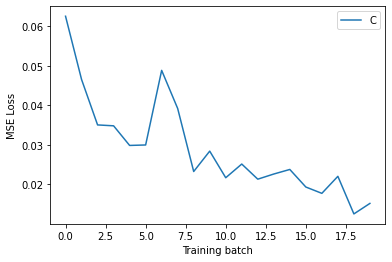

In [ ]:
# o/p_size = (i/p_size - kernel_size + 2*padding_size)/stride + 1  --> Conv
# 268 - 3 + 0 + 1 = 266
# 133 - 3 +1 = 131
# 66-3+0+1=64
# 32 - 3 + 0 + 1 = 30
# # i/p_size = (o/p_size - 1)*stride - 2*padding_size + kernel_size --> ConvTranspose
# 12*3 - 2*5 + 5 = 31
# 30*2 - 0 + 5 = 65
# 64*2 - 0 + 3 = 124--> 131
# 130*2 - 0 + 6 = 184 --> 266
# 265*1 -0 + 3 = 268
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(32, 16, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
            )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
            )
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  # out_shape: (b, 32, 266, 266)    # out_channels=num filters
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(kernel_size=2, stride=2),  # b, 32, 133, 133
        #     nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),  # b, 16, 131, 131
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(kernel_size=2, stride=2),  # b, 8, 66, 66
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),  # b, 16, 64, 64
        #     nn.ReLU(inplace=True),
         
        # )
    
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),  # b, 16, 29, 29
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),  # b, 32, 60, 60
        #     nn.ReLU(True),
        #     nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1),  # b, 32, 122, 122
        #     nn.Sigmoid()
        # )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

## Uncomment to test your solution
trained_conv_AE = autoencoder()
#assert trained_conv_AE.encode(train_set[0][0].unsqueeze(0)).numel() == K, "Encoder output size should be K!"
conv_losses = train_autoencoder(trained_conv_AE, train_set, device=DEVICE, seed=SEED)
#plot_conv_ae(conv_losses)
plt.plot(conv_losses)
plt.legend('Conv AE')
plt.xlabel('Training batch')
plt.ylabel('MSE Loss')

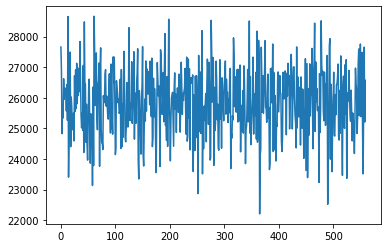

In [ ]:
plt.plot(conv_losses)

torch.Size([1, 16, 21, 21])
(256, 256, 3)
torch.Size([1, 16, 21, 21])
(256, 256, 3)
torch.Size([1, 16, 21, 21])
(256, 256, 3)
torch.Size([1, 16, 21, 21])
(256, 256, 3)
torch.Size([1, 16, 21, 21])
(256, 256, 3)
torch.Size([1, 16, 21, 21])
(256, 256, 3)
torch.Size([1, 16, 21, 21])
(256, 256, 3)
torch.Size([1, 16, 21, 21])
(256, 256, 3)
torch.Size([1, 16, 21, 21])
(256, 256, 3)
torch.Size([1, 16, 21, 21])
(256, 256, 3)


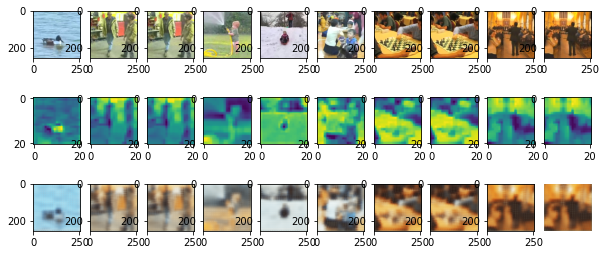

In [ ]:
# Visualize the reconstructions $\mathbf{x}'$

n_plot = 10
plt.figure(figsize=(10, 4.5))
for i in range(n_plot):
# for i in range(1):
  
  im_input = data_torch[i, :, :256, :256].unsqueeze(0)/255.

  # idx = torch.randint(len(train_set), size=())
  # image, _ = train_set[idx]
  # Get reconstructed image from autoencoder
  with torch.no_grad():
      reconstruction = trained_conv_AE(im_input)
    # reconstruction = trained_conv_AE(image.unsqueeze(0)).reshape(image.size())
  # Get reconstruction from PCA dimensionality reduction
  # h_pca = pca_encode(image)
  # recon_pca = pca_decode(h_pca).reshape(image.size())

  image = im_input[0].permute(1, 2, 0).detach().cpu().numpy()
  tmp_image= im_input[0].permute(0, 1, 2).detach().cpu().numpy()
  #print(image.shape)
  #tmp_image=to_grayscale(image)
  latent_image = trained_conv_AE.encoder(im_input)
  print(latent_image.shape)
  #gray_activations = to_grayscale(x[0]).detach().cpu().numpy()
  reconstruction = reconstruction[0].permute(1, 2, 0).detach().cpu().numpy()
  print(reconstruction.shape)

  plt.subplot(3, n_plot, i + 1)
  plt.imshow(image)
  # plot_torch_image(im_input)
  #if i == 0:
   # plt.ylabel('Original\nImage')

  plt.subplot(3, n_plot, i + 1 + n_plot)

  # Plot latent MEAN
  latent_np = torch.mean(latent_image[0], dim=0).detach().cpu().numpy()
  plt.imshow(latent_np/latent_np.max())

  # Plot latent First 3 channels
  # latent_np = latent_image[0].permute(1,2,0).detach().cpu().numpy()
  # plt.imshow(latent_np[:,:,:3]/latent_np[:,:,:3].max())

  # Plot latent channel idx_latent
  idx_latent = 5
  latent_np = latent_image[0].permute(1,2,0).detach().cpu().numpy()
  #plt.imshow(latent_np[:,:,idx_latent]/latent_np[:,:,idx_latent].max())

  plt.subplot(3, n_plot, i + 1 + 2*n_plot)
  plt.imshow(reconstruction)
  # plot_torch_image(reconstruction)
  # if i == 0:
  #   plt.ylabel(f'Conv AE\n(K={K})')

  # plt.subplot(3, n_plot, i + 1 + 2*n_plot)
  # plot_torch_image(recon_pca)
  # if i == 0:
  #   plt.ylabel(f'PCA\n(K={K})')
plt.axis('off')
plt.show()

In [ ]:
# modules() ? TODO: Does it work?
modules_encoder = autoencoder.encoder.modules()

input_image = (1, 3, 256, 256)

# tmp_x = input_image

# latent_images = []

# for module in modules_encoder:

#   tmp_x = module(tmp_x)

#   gray_activations = to_grayscale(tmp_x[0])
#   latent_images.append(gray_activations)




# 1, 8, h', w'
x = trained_conv_AE.encoder(input_image)
gray_activations = to_grayscale(x[0])





NameError: ignored

# Define the required functions

In [ ]:
def train_autoencoder(autoencoder, dataset, device, epochs=20, batch_size=32,
                      seed=0):
  autoencoder.to(device)
  optim = torch.optim.Adam(autoencoder.parameters(),
                           lr=1e-3,
                           weight_decay=1e-5)
  loss_fn = nn.MSELoss()
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=2,
                      worker_init_fn=seed_worker,
                      generator=g_seed)

  mse_loss = torch.zeros(epochs * len(dataset) // batch_size, device=device)
  i = 0
  for epoch in trange(epochs, desc='Epoch'):
    #for im_batch, _ in dataset:
    for im_batch in dataset:
      print(im_batch.shape)
      im_batch = im_batch.to(device)
      optim.zero_grad()
      reconstruction = autoencoder(im_batch.float())
      # write the loss calculation
      loss = loss_fn(reconstruction.view(batch_size, -1),
                     target=im_batch.view(batch_size, -1))
      loss.backward()
      optim.step()

      mse_loss[i] = loss.detach()
      i += 1
  # After training completes, make sure the model is on CPU so we can easily
  # do more visualizations and demos.
  autoencoder.to('cpu')
  #return torch.array(mse_loss)
  return mse_loss.cpu()

In [ ]:
# helper function cout(torch.Tensor, nn.Conv2D) to calculate the output shape of a nn.Conv2D layer given a tensor with shape (channels, height, width)
def cout(x, layer):
  """Unnecessarily complicated but complete way to
  calculate the output depth, height and width size for a Conv2D layer

  Args:
    x (tuple): input size (depth, height, width)
    layer (nn.Conv2d): the Conv2D layer

  returns:
    (int): output shape as given in [Ref]

  Ref:
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
  """
  assert isinstance(layer, nn.Conv2d)
  p = layer.padding if isinstance(layer.padding, tuple) else (layer.padding,)
  k = layer.kernel_size if isinstance(layer.kernel_size, tuple) else (layer.kernel_size,)
  d = layer.dilation if isinstance(layer.dilation, tuple) else (layer.dilation,)
  s = layer.stride if isinstance(layer.stride, tuple) else (layer.stride,)
  in_depth, in_height, in_width = x
  out_depth = layer.out_channels
  out_height = 1 + (in_height + 2 * p[0] - (k[0] - 1) * d[0] - 1) // s[0]
  out_width = 1 + (in_width + 2 * p[-1] - (k[-1] - 1) * d[-1] - 1) // s[-1]
  return (out_depth, out_height, out_width)

In [ ]:
#define BiasLayer
class BiasLayer(nn.Module):
  def __init__(self, shape):
    super(BiasLayer, self).__init__()
    init_bias = torch.zeros(shape)
    self.bias = nn.Parameter(init_bias, requires_grad=True)

  def forward(self, x):
    return x + self.bias

In [ ]:
class ConvAutoEncoder(nn.Module):
  def __init__(self, x_dim, h_dim, n_filters=32, filter_size=5):
    """A Convolutional AutoEncoder

    Args:
      x_dim (tuple): input dimensions (height, widths, channels)
      h_dim (int): hidden dimension, bottleneck dimension, K
      n_filters (int): number of filters (number of output channels)
      filter_size (int): kernel size
    """
    super().__init__()
    channels, height, widths = x_dim

    # encoder input bias layer
    self.enc_bias = BiasLayer(x_dim)

    # first encoder conv2d layer
    self.enc_conv_1 = nn.Conv2d(channels, n_filters, filter_size)

    # output shape of the first encoder conv2d layer given x_dim input
    conv_1_shape = cout(x_dim, self.enc_conv_1)

    print(conv_1_shape)

    # second encoder conv2d layer
    self.enc_conv_2 = nn.Conv2d(n_filters, n_filters, filter_size)

    # output shape of the second encoder conv2d layer given conv_1_shape input
    conv_2_shape = cout(conv_1_shape, self.enc_conv_2)

    print(conv_2_shape)

    # The bottleneck is a dense layer, therefore we need a flattenning layer
    self.enc_flatten = nn.Flatten()

    # conv output shape is (depth, height, width), so the flatten size is:
    flat_after_conv = conv_2_shape[0] * conv_2_shape[1] * conv_2_shape[2]

    print(flat_after_conv)

    # encoder Linear layer
    self.enc_lin = nn.Linear(flat_after_conv, h_dim)

    # decoder Linear layer
    self.dec_lin = nn.Linear(h_dim, flat_after_conv)

    # unflatten data to (depth, height, width) shape
    self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=conv_2_shape)

    # first "deconvolution" layer
    self.dec_deconv_1 = nn.ConvTranspose2d(n_filters, n_filters, filter_size)

    # second "deconvolution" layer
    self.dec_deconv_2 = nn.ConvTranspose2d(n_filters, channels, filter_size)

    # decoder output bias layer
    self.dec_bias = BiasLayer(x_dim)

  def encode(self, x):
    s = self.enc_bias(x)
    s = F.relu(self.enc_conv_1(s))
    s = F.relu(self.enc_conv_2(s))
    s = self.enc_flatten(s)
    h = self.enc_lin(s)
    return h

  def decode(self, h):
    s = F.relu(self.dec_lin(h))
    s = self.dec_unflatten(s)
    s = F.relu(self.dec_deconv_1(s))
    s = self.dec_deconv_2(s)
    x_prime = self.dec_bias(s)
    return x_prime

  def forward(self, x):
    return self.decode(self.encode(x))

K = 100
## Uncomment to test your solution
trained_conv_AE = ConvAutoEncoder(data_shape, K)
#assert trained_conv_AE.encode(train_set[0][0].unsqueeze(0)).numel() == K, "Encoder output size should be K!"
conv_losses = train_autoencoder(trained_conv_AE, train_set, device=DEVICE, seed=SEED)
plot_conv_ae(lin_losses, conv_losses)

(32, 264, 264)
(32, 260, 260)
2163200


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([32, 3, 268, 268])


RuntimeError: ignored